In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_data_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'


## Hyperparameters

In [3]:
kernel_size_cnn = 3
kernel_size_pool = 2
stride1 = 1
stride2 = 2
padding = 1
batch_size = 128
epochs = 50
ratio = 64
in_channels = 3
hidden_channels1 = 64
hidden_channels2 = 128

## Data Viz

In [4]:
from PIL import Image
img = Image.open('/kaggle/input/intel-image-classification/seg_train/seg_train/forest/10007.jpg')
img.size

(150, 150)

In [5]:
train_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(train_data_dir):
    name.append(i)
    counts.append(len(os.listdir(train_data_dir+'/'+i)))
train_df['Name'] = name
train_df['Counts'] = counts
train_df.head()

,Name,Counts
0,mountain,2512
1,street,2382
2,buildings,2191
3,sea,2274
4,forest,2271


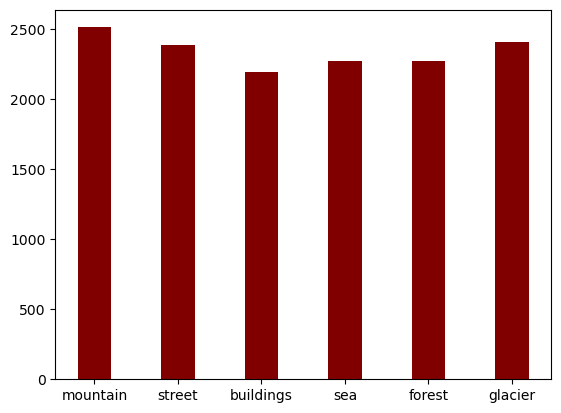

In [6]:
plt.bar(train_df['Name'], train_df['Counts'], color ='maroon',width = 0.4);

In [7]:
test_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(test_data_dir):
    
    name.append(i)
    counts.append(len(os.listdir(test_data_dir+'/'+i)))
test_df['Name'] = name
test_df['Counts'] = counts
test_df.head()

,Name,Counts
0,mountain,525
1,street,501
2,buildings,437
3,sea,510
4,forest,474


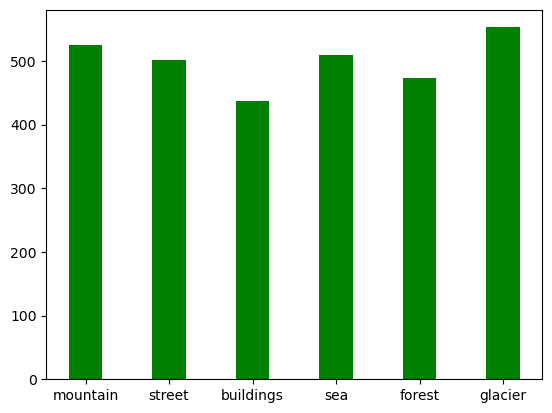

In [8]:
plt.bar(test_df['Name'], test_df['Counts'], color ='green',width = 0.4);

In [9]:
train_df['Counts'].sum(), test_df['Counts'].sum()

(14034, 3000)

## Finding Mean and Standard deviation to normalize images

In [10]:
train = datasets.ImageFolder(train_data_dir,
                   transform = transforms.Compose([
                       transforms.Resize(ratio),
                       transforms.RandomCrop(ratio),
                       transforms.ToTensor()
                   ]))
train_data_loader = torch.utils.data.DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
len(train_data_loader) * 64

14080

In [12]:
def get_mean_std(data_loader):
    sum_, squared_sum, batches = 0, 0, 0
    for data, _ in data_loader:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim=([0, 2, 3]))
        batches += 1
    
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5
    return mean, std

In [13]:
mean, std = get_mean_std(train_data_loader)
mean, std

(tensor([0.4302, 0.4575, 0.4540]), tensor([0.2480, 0.2467, 0.2806]))

## Seeding

In [14]:
random_seed = 42
torch.manual_seed(random_seed)

## Transforms

In [15]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(ratio),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
    transforms.Resize(ratio),
    transforms.CenterCrop(ratio),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

            

In [16]:
train_transform

Compose(
    RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4302, 0.4575, 0.4540]), std=tensor([0.2480, 0.2467, 0.2806]))
)

In [17]:
test_transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=tensor([0.4302, 0.4575, 0.4540]), std=tensor([0.2480, 0.2467, 0.2806]))
)

## Converting into datasets

In [18]:
train_datasets = datasets.ImageFolder(os.path.join(train_data_dir),
                                      transform=train_transform)
test_datasets = datasets.ImageFolder(os.path.join(test_data_dir),
                                    transform=test_transform)

In [19]:
len(train_datasets), len(test_datasets)

(14034, 3000)

In [20]:
train_datasets.classes, test_datasets.classes

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [21]:
classes = len(train_datasets.classes)
classes

6

In [22]:
val_size = int(len(train_datasets) * 0.2)
train_size = len(train_datasets) - val_size
train_datasets, val_datasets = torch.utils.data.random_split(train_datasets,
                                                             [train_size, val_size])
len(train_datasets), len(val_datasets), len(test_datasets)

(11228, 2806, 3000)

In [23]:
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size * 2, shuffle=True,
                                                num_workers=2, pin_memory=True)
val_dataloaders = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size * 2,
                                              num_workers=2, pin_memory=True)
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size * 2,
                                               num_workers=2, pin_memory=True)

In [24]:
len(train_dataloaders), len(val_dataloaders), len(test_dataloaders)

(44, 11, 12)

In [25]:
len(train_dataloaders) * batch_size * 2, len(val_dataloaders) * batch_size * 2, len(test_dataloaders) * batch_size * 2

(11264, 2816, 3072)

## Data Viz

In [26]:
def denormalize(images, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return images * std + mean

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, mean, std)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

/tmp/ipykernel_28/3427750598.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).reshape(1, 3, 1, 1)
/tmp/ipykernel_28/3427750598.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).reshape(1, 3, 1, 1)


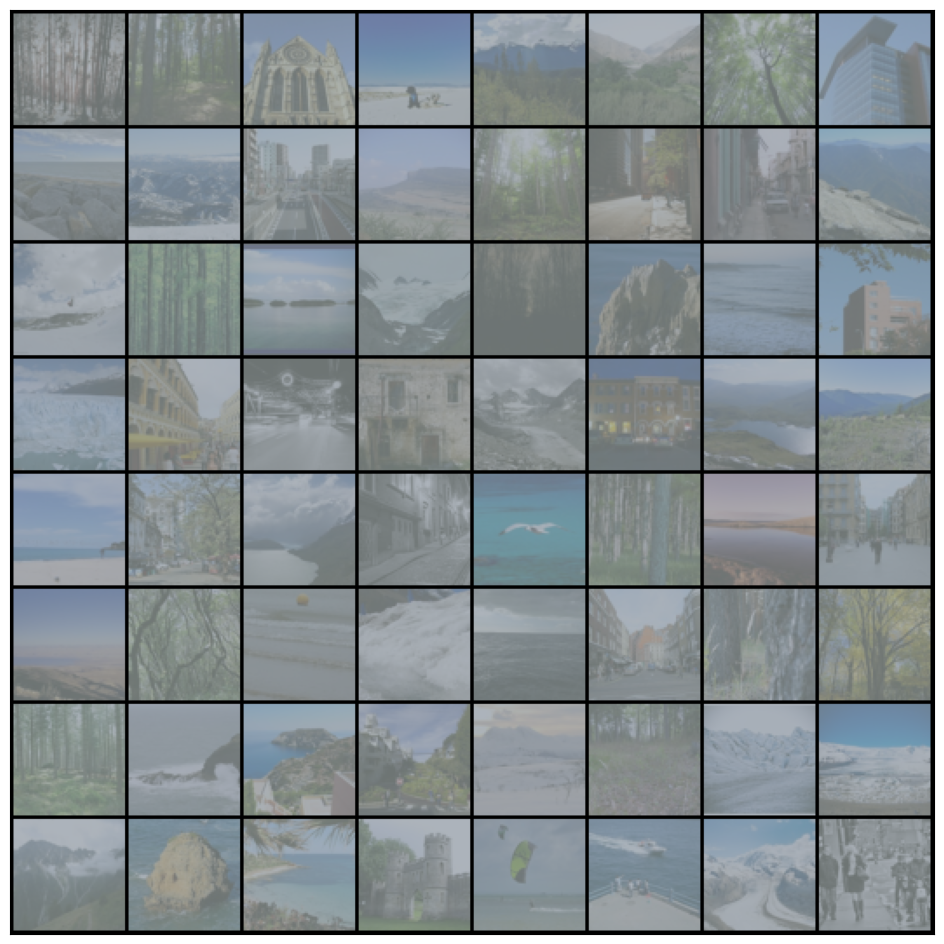

In [27]:
show_batch(train_data_loader)

## Changing from CPU to GPU if available

In [28]:
CUDA = torch.cuda.is_available()
CUDA

True

# CNN

## Simple CNN

### Try Dropout vs Batch Norm and MaxPool2d vs Conv2d with stride=2

In [29]:
class CNN1(nn.Module):
    # in_channels is the color channels in our case it is 3
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        # padding_value = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size_pool)
        
        
        
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels2,
                             kernel_size=kernel_size_cnn,
                             stride=stride1,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 32768
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        # input_size = [batch_size, w, h, input_channels]
        # [256, 64, 64, 3]
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        # [((input_size - kernel_size) + (2 * padding)) / stride + 1]
        # [((64 - 3) + 2(1)) / 1 + 1] = 64
        # [batch_size, w, h, hidden_channels1]
        # [256, 64, 64, 64]
        out = self.relu(out)
        out = self.maxpool(out)
        # input / 2 = [256, 32, 32, 64]
        
        # input = [256, 32, 32, 64]
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        # [batch_size, w, h, hidden_channels2]
        # [256, 32, 32, 128]
        
        # [((input_size - kernel_size) + (2 * padding)) / stride + 1]
        # [((32 - 3) + 2(1)) / 1 + 1] => 32
        out = self.relu(out)
        out = self.maxpool(out)
        # input /2 => [256, 16, 16, 128]
        
        out = self.fc1(out)
#         print(out.shape[1])
        # 16 * 16 * 128 = 32,768
        self.linear_layer = out.shape[1]
#         print(self.linear_layer)
        out = self.relu(out)
        out = self.fc2(out)
        return out
        

In [30]:

model = CNN1(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model = model.cuda()
model

CNN1(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=32768, out_features=6, bias=True)
)

## Loss Function and Optimizer
As this is a multi class classification and our outputs are not sigmoid outputs so cross entropy loss would be ideal

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training and testing phase

In [32]:
iterations = 0
correct = 0

for i, (inputs, labels) in enumerate(train_dataloaders):
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("One Iteration")
    print(f"Input shape: {inputs.shape}\tLabels shape: {labels.shape}")
    output = model(inputs)
    
    _, predicted = torch.max(output, 1)
    
    print('Predicted shape: ', predicted.shape)
    print('Predicted tensor: ', predicted)
    
    correct += (predicted == labels).sum()
    break

One Iteration
Input shape: torch.Size([256, 3, 64, 64])	Labels shape: torch.Size([256])
32768
Predicted shape:  torch.Size([256])
Predicted tensor:  tensor([1, 5, 0, 5, 5, 5, 1, 5, 5, 0, 1, 1, 1, 1, 1, 5, 5, 5, 2, 3, 2, 5, 1, 2,
        5, 5, 1, 5, 1, 5, 5, 5, 5, 1, 1, 5, 5, 5, 1, 5, 1, 5, 2, 5, 5, 1, 1, 5,
        5, 5, 5, 5, 5, 1, 5, 5, 5, 2, 2, 0, 1, 1, 5, 5, 1, 1, 5, 5, 5, 5, 1, 5,
        5, 5, 2, 1, 5, 0, 1, 5, 1, 2, 5, 5, 0, 2, 1, 2, 1, 5, 0, 5, 1, 0, 5, 3,
        1, 1, 5, 5, 5, 0, 2, 5, 2, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 1, 5, 0,
        1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 2, 5, 2, 5, 5, 2, 1, 5, 5, 1, 5, 5,
        1, 1, 1, 1, 2, 2, 0, 5, 1, 5, 1, 1, 2, 1, 5, 5, 5, 2, 1, 5, 2, 1, 5, 5,
        1, 5, 5, 1, 5, 5, 0, 1, 1, 1, 1, 5, 1, 1, 5, 5, 2, 5, 3, 1, 5, 5, 2, 1,
        5, 2, 5, 2, 2, 1, 1, 5, 2, 1, 5, 5, 2, 0, 2, 5, 5, 0, 2, 1, 5, 5, 0, 5,
        5, 5, 1, 5, 5, 3, 5, 5, 5, 2, 1, 2, 1, 2, 5, 5, 2, 2, 5, 5, 5, 2, 5, 3,
        5, 2, 5, 1, 5, 5, 1, 2, 5, 5, 5, 2, 2, 5, 0

In [36]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0
    model.train()
    
    for i, (inputs, labels) in enumerate(train_dataloaders):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        iterations += 1
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(train_datasets)))
    print(f"Epoch [{epoch + 1} / {epochs}], Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}")
    

Epoch [1 / 50], Training Loss: 2.047, Training Accuracy: 16.548
Epoch [2 / 50], Training Loss: 2.042, Training Accuracy: 16.655
Epoch [3 / 50], Training Loss: 2.042, Training Accuracy: 16.601
Epoch [4 / 50], Training Loss: 2.041, Training Accuracy: 16.699
Epoch [5 / 50], Training Loss: 2.042, Training Accuracy: 16.637
Epoch [6 / 50], Training Loss: 2.043, Training Accuracy: 16.272
Epoch [7 / 50], Training Loss: 2.044, Training Accuracy: 16.717
Epoch [8 / 50], Training Loss: 2.044, Training Accuracy: 16.521
Epoch [9 / 50], Training Loss: 2.038, Training Accuracy: 16.254
Epoch [10 / 50], Training Loss: 2.041, Training Accuracy: 16.744
Epoch [11 / 50], Training Loss: 2.047, Training Accuracy: 16.432
Epoch [12 / 50], Training Loss: 2.048, Training Accuracy: 16.254
Epoch [13 / 50], Training Loss: 2.038, Training Accuracy: 16.566
Epoch [14 / 50], Training Loss: 2.046, Training Accuracy: 16.432
Epoch [15 / 50], Training Loss: 2.041, Training Accuracy: 16.441
Epoch [16 / 50], Training Loss: 2.

tensor([[[-0.2143, -0.3308, -1.1172,  ..., -1.2628, -1.1608, -1.3647],
         [-0.3308, -0.0832,  0.2372,  ..., -0.9570, -1.0298, -1.4521],
         [-0.3308, -0.0104,  0.5284,  ..., -1.2337, -0.9715, -1.2337],
         ...,
         [-0.9861, -1.2045,  0.5721,  ..., -0.7822,  0.1061, -0.2434],
         [-0.7531,  0.7905,  0.3100,  ..., -0.2871, -0.1123, -0.3162],
         [-0.0541,  0.8633,  0.2080,  ..., -1.2191, -0.3017, -0.1997]],

        [[-0.0099, -0.1270, -0.9177,  ..., -1.2691, -1.2105, -1.4155],
         [-0.1416,  0.1219,  0.4294,  ..., -0.9470, -1.0641, -1.4887],
         [-0.1709,  0.1659,  0.6783,  ..., -1.2252, -1.0055, -1.2691],
         ...,
         [-0.6980, -0.8884,  0.9419,  ..., -0.6834,  0.1659, -0.2441],
         [-0.4638,  1.0883,  0.6783,  ..., -0.2148, -0.0977, -0.3173],
         [ 0.2684,  1.1908,  0.6051,  ..., -1.2105, -0.2881, -0.2002]],

        [[-0.7725, -0.8777, -1.4168,  ..., -1.4300, -1.3511, -1.4826],
         [-0.9171, -0.7330, -0.4438,  ..., -1

## Feature representation

In [29]:
from PIL import Image
img = Image.open('/kaggle/input/intel-image-classification/seg_train/seg_train/forest/10007.jpg')
img.size
image = train_transform(img)
image = image.unsqueeze(0)
if CUDA:
    image = image.cuda()
image.shape

torch.Size([1, 3, 64, 64])

### One

In [30]:
class CNN11(nn.Module):
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size_pool)
        
        
        
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels2,
                             kernel_size=kernel_size_cnn,
                             stride=stride1,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 32768
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        outputs = []
        labels = []
        out = self.cnn1(x)
        outputs.append(out)
        labels.append('conv2d')
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        
        out = self.cnn2(out)
        outputs.append(out)
        labels.append('conv2d')
        out = self.batchnorm2(out)
        outputs.append(out)
        labels.append('BatchNorm')
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        
        out = self.fc1(out)
        
        self.linear_layer = out.shape[1]
        
        out = self.relu(out)
        out = self.fc2(out)
        return outputs, labels
        

In [31]:
model11 = CNN11(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model11 = model11.cuda()

In [32]:
outputs, labels = model11(image)

In [33]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())



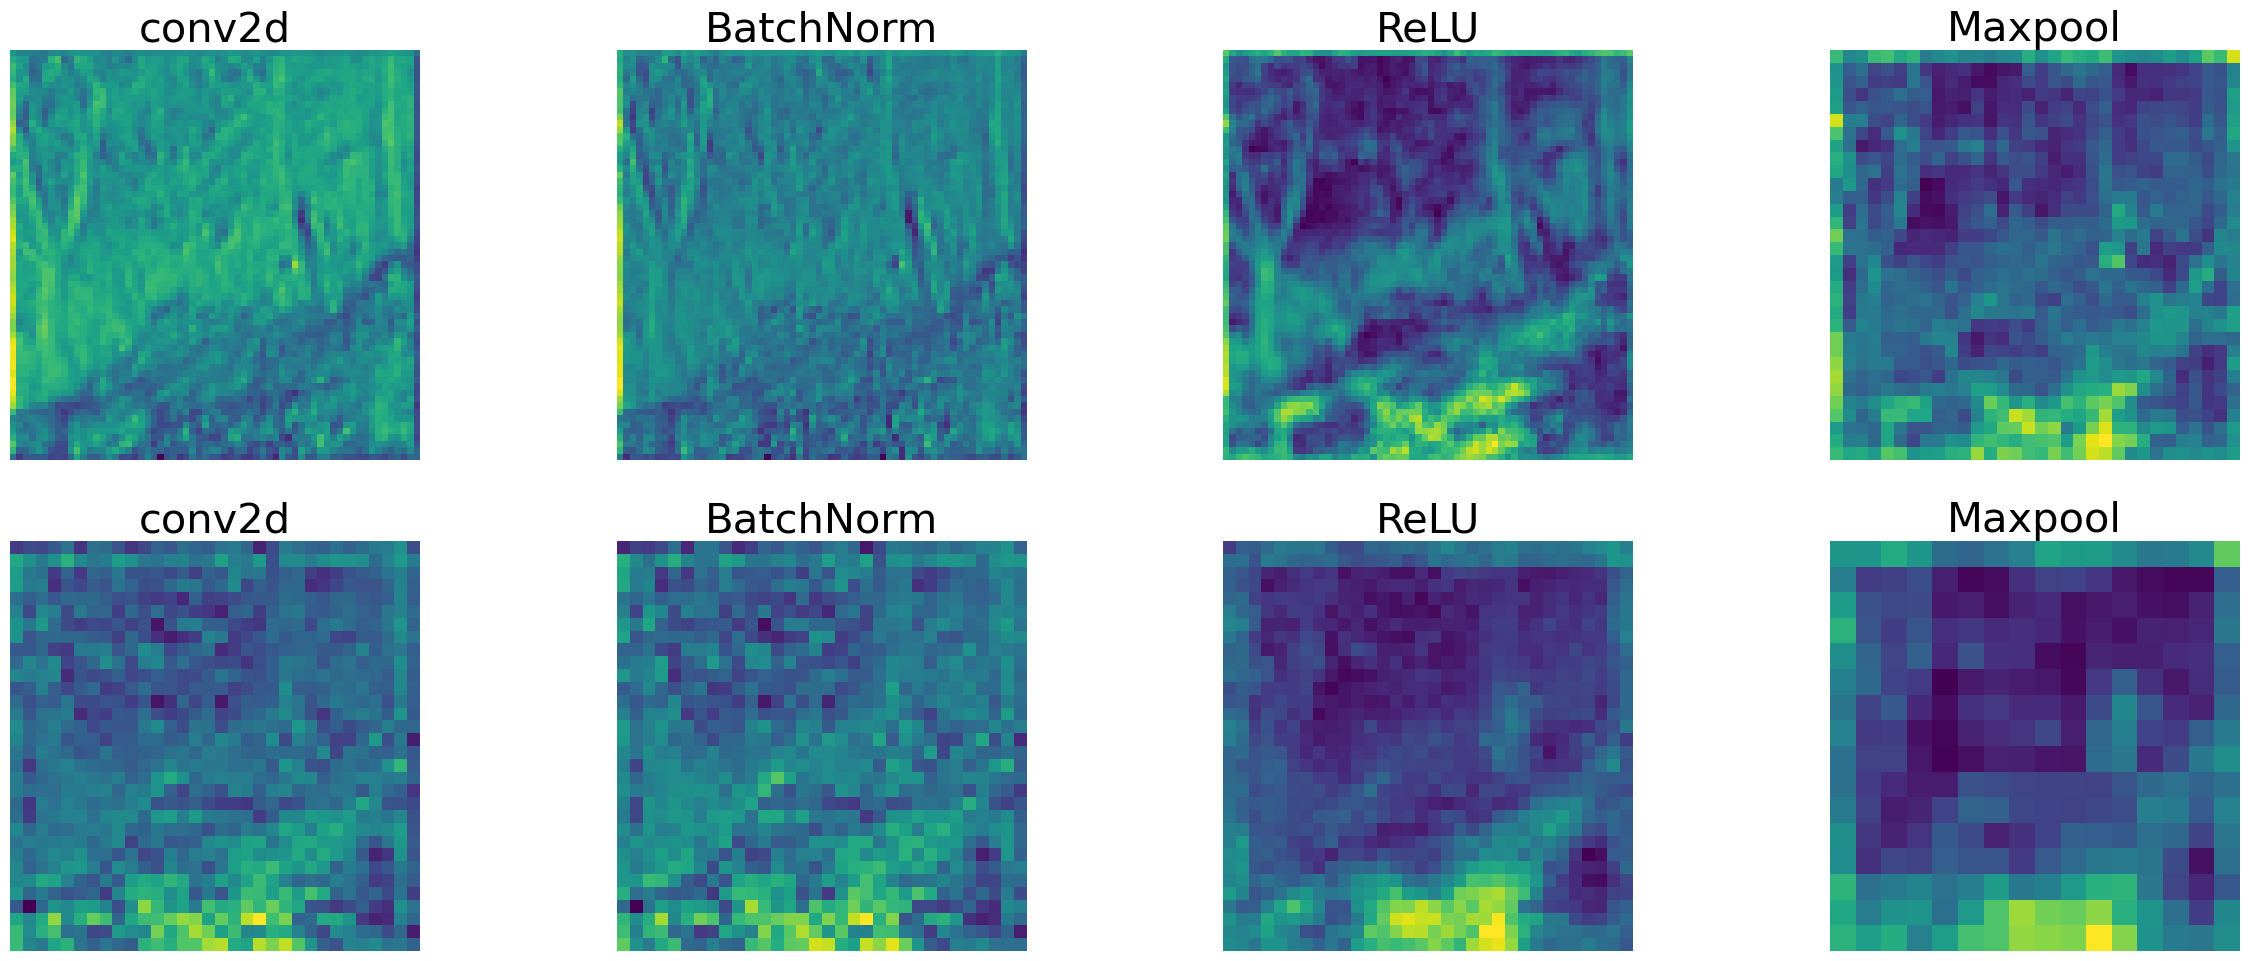

In [35]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(8, 4, i + 1)
    imgplot = plt.imshow(processed[i])
    plt.axis('off')
    a.set_title(labels[i], fontsize=30)
    
plt.savefig('feature_maps1.jpg', bbox_inches='tight')

## Two

In [36]:
class CNN2(nn.Module):
    # in_channels is the color channels in our case it is 3
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        # padding_value = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size_pool)
        
        
        
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels1,
                             kernel_size=kernel_size_cnn,
                             stride=stride1,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 1024
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        
        outputs = []
        labels = []
        
        out = self.cnn1(x)
        outputs.append(out)
        labels.append('conv2d')
        
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
                
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('MaxPool')
        # [256, 32, 32, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
    
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        # [256, 16, 16, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        # [256, 8, 8, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        
        # [256, 4, 4, 64]
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        
        return outputs, labels
        

In [37]:
model1 = CNN2(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model1 = model1.cuda()

In [38]:
outputs, labels = model1(image)

In [39]:
len(labels), len(outputs)

(16, 16)

In [40]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())


In [41]:
processed[-1].shape

(4, 4)

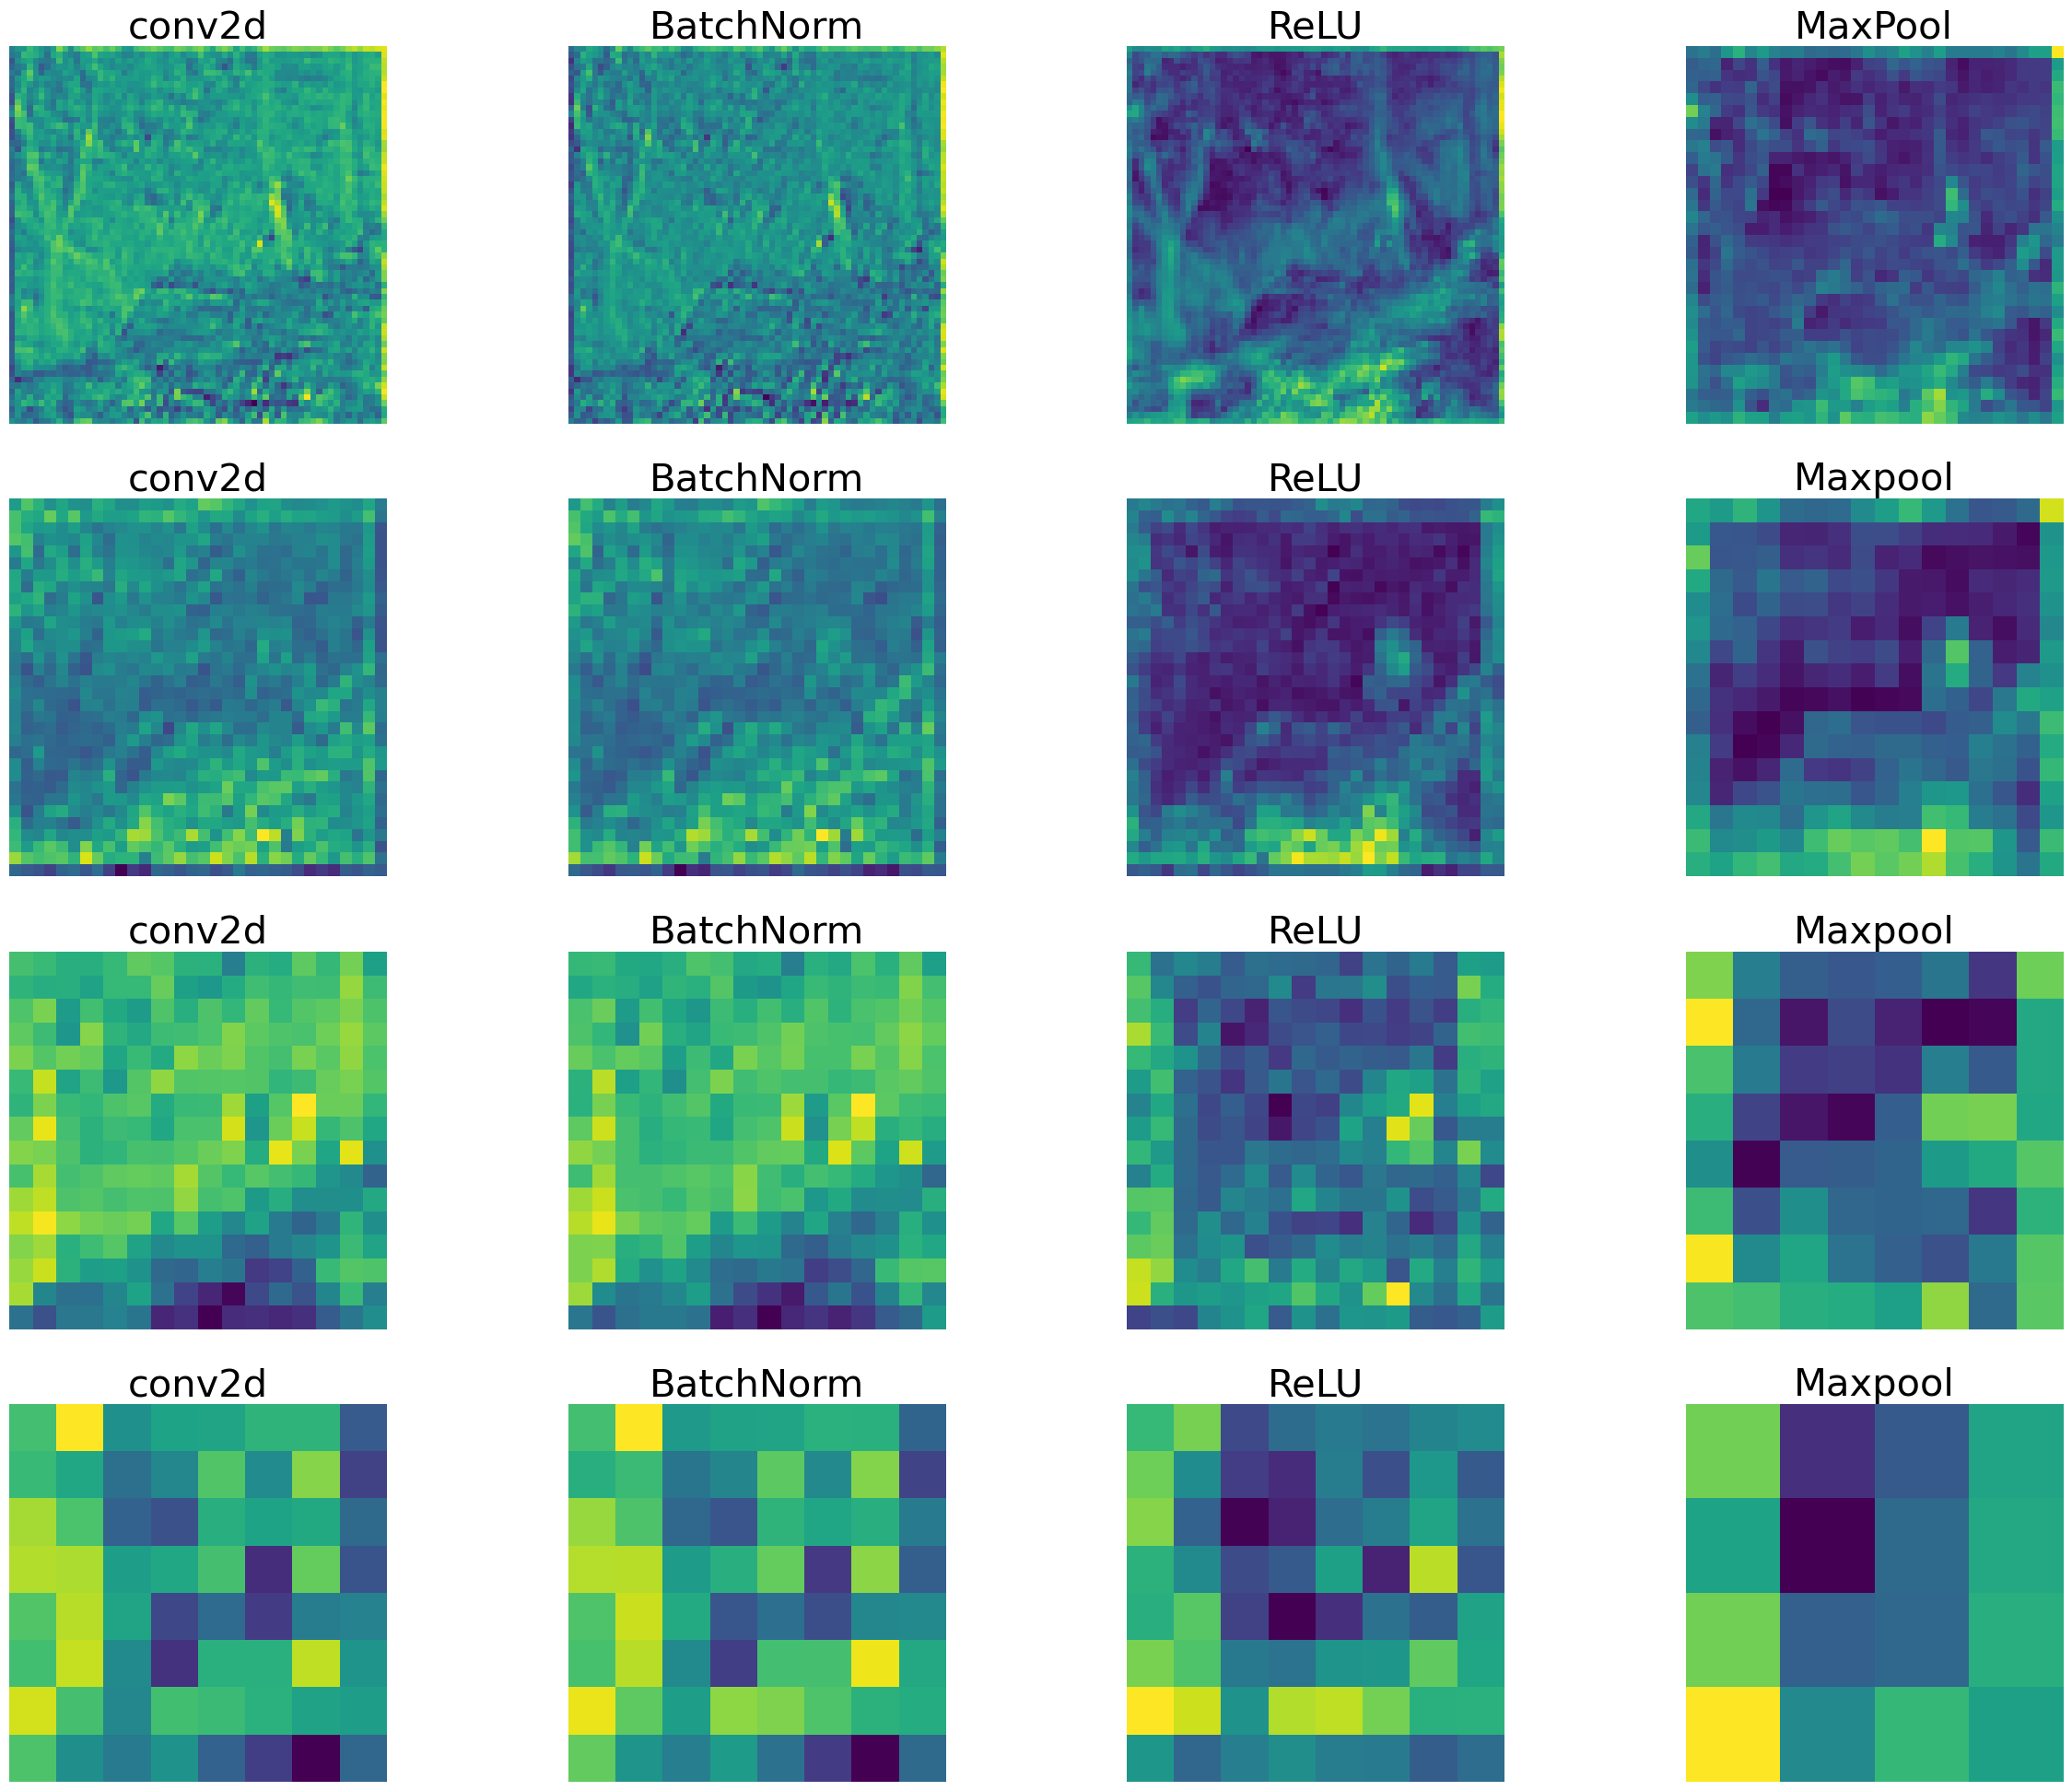

In [42]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(8, 4, i + 1)
    imgplot = plt.imshow(processed[i])
    plt.axis('off')
    a.set_title(labels[i], fontsize=30)
    
plt.savefig('feature_maps2.jpg', bbox_inches='tight')

In [46]:
class CNN22(nn.Module):
    # in_channels is the color channels in our case it is 3
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        # padding_value = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size_pool)
        
        
        
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels1,
                             kernel_size=kernel_size_cnn,
                             stride=stride1,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 1024
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        
        outputs = []
        labels = []
        
        out = self.cnn1(x)
        outputs.append(out)
        labels.append('conv2d')
        
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
                
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('MaxPool')
        # [256, 32, 32, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
    
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        # [256, 16, 16, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        # [256, 8, 8, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        
        # [256, 4, 4, 64]
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        
        return out
        

In [47]:
model = CNN22(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [48]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0
    model.train()
    
    for i, (inputs, labels) in enumerate(train_dataloaders):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        iterations += 1
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(train_datasets)))
    print(f"Epoch [{epoch + 1} / {epochs}], Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}")
    

Epoch [1 / 50], Training Loss: 1.571, Training Accuracy: 44.968
Epoch [2 / 50], Training Loss: 1.038, Training Accuracy: 59.503
Epoch [3 / 50], Training Loss: 0.952, Training Accuracy: 63.529
Epoch [4 / 50], Training Loss: 0.848, Training Accuracy: 68.899
Epoch [5 / 50], Training Loss: 0.788, Training Accuracy: 70.315
Epoch [6 / 50], Training Loss: 0.778, Training Accuracy: 71.170
Epoch [7 / 50], Training Loss: 0.723, Training Accuracy: 73.156
Epoch [8 / 50], Training Loss: 0.722, Training Accuracy: 73.254
Epoch [9 / 50], Training Loss: 0.668, Training Accuracy: 74.840
Epoch [10 / 50], Training Loss: 0.658, Training Accuracy: 75.472
Epoch [11 / 50], Training Loss: 0.653, Training Accuracy: 76.006
Epoch [12 / 50], Training Loss: 0.617, Training Accuracy: 77.048
Epoch [13 / 50], Training Loss: 0.631, Training Accuracy: 76.354
Epoch [14 / 50], Training Loss: 0.610, Training Accuracy: 77.752
Epoch [15 / 50], Training Loss: 0.585, Training Accuracy: 78.295
Epoch [16 / 50], Training Loss: 0.

### Three

In [47]:
class CNN3(nn.Module):
    # in_channels is the color channels in our case it is 3
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        # padding_value = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        # [((input_size - kernel_size) + (2 * padding)) / stride + 1]
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels1,
                             kernel_size=kernel_size_cnn,
                             stride=stride2,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 1024
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        
        outputs = []
        labels = []
        
        out = self.cnn1(x)
        outputs.append(out)
        labels.append('conv2d')
        
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
                
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('MaxPool')
        # [256, 32, 32, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
    
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('Maxpool')
        # [256, 16, 16, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('Maxpool')
        # [256, 8, 8, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('Maxpool')
        
        # [256, 4, 4, 64]
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        
        return outputs, labels
        

In [48]:
model1 = CNN3(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model1 = model1.cuda()

In [49]:
outputs, labels = model1(image)

In [50]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())


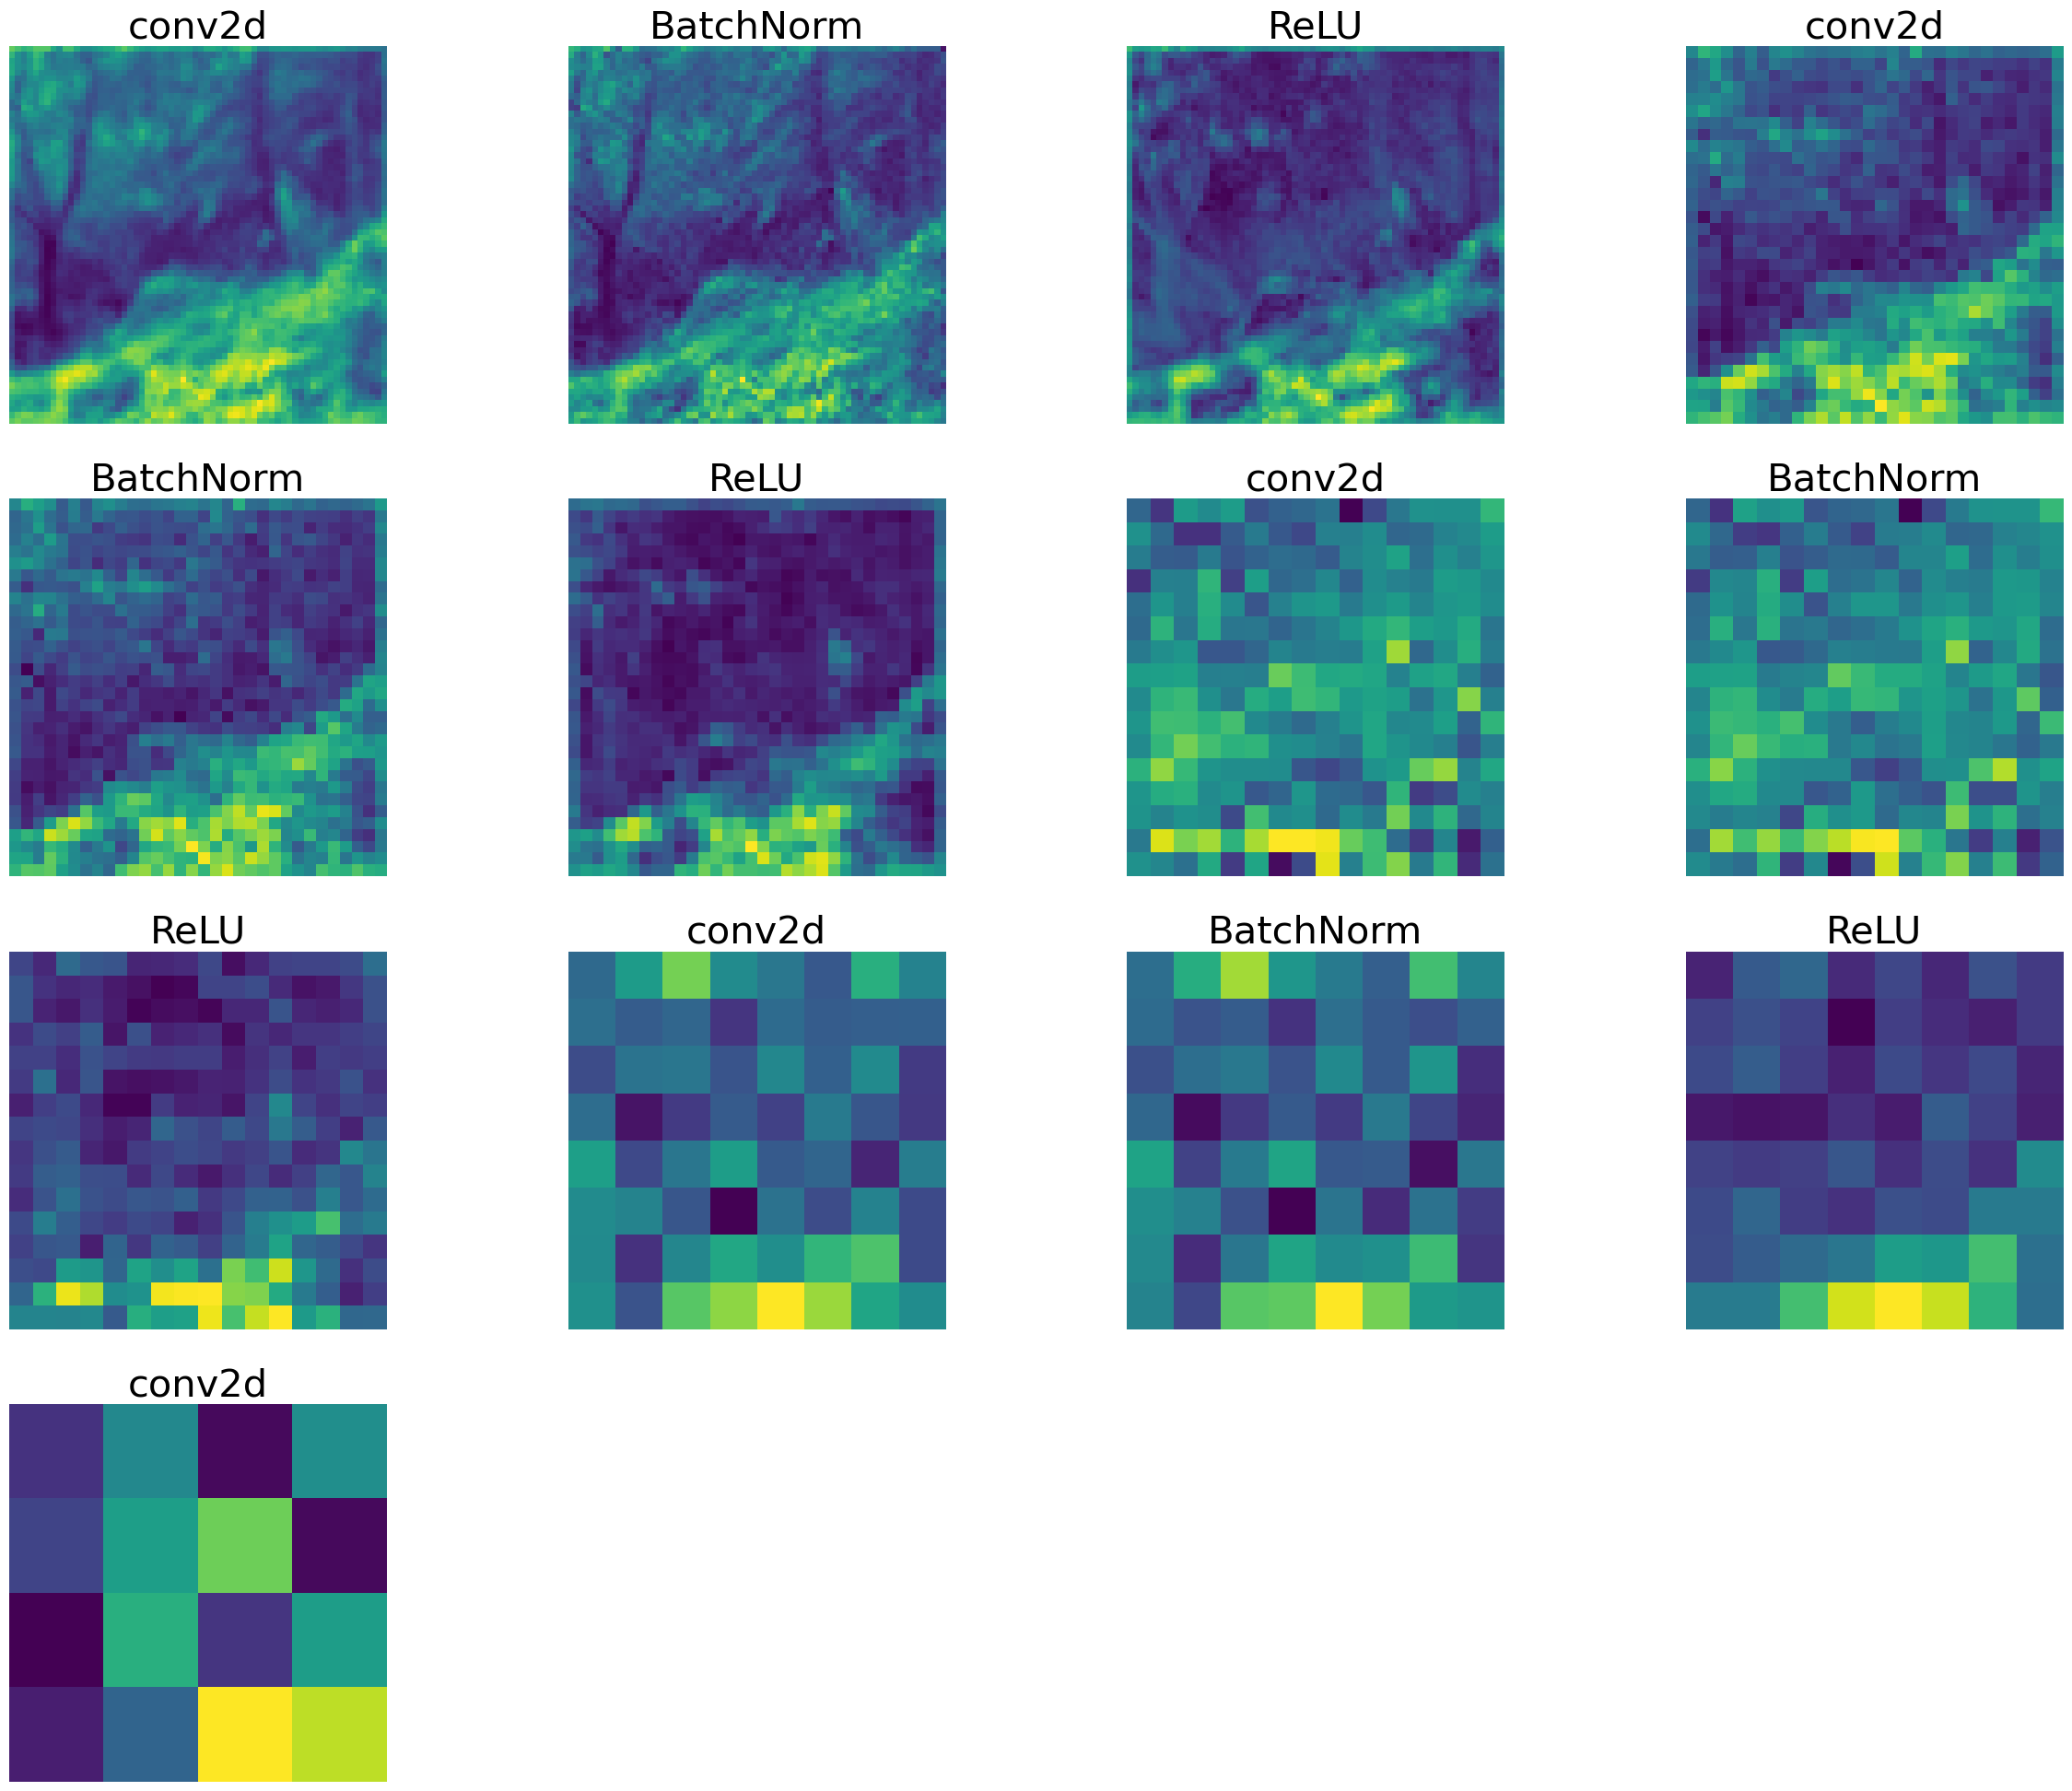

In [51]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(8, 4, i + 1)
    imgplot = plt.imshow(processed[i])
    plt.axis('off')
    a.set_title(labels[i], fontsize=30)
    
plt.savefig('feature_maps3.jpg', bbox_inches='tight')

In [29]:
class CNN33(nn.Module):
    # in_channels is the color channels in our case it is 3
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        # padding_value = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        # [((input_size - kernel_size) + (2 * padding)) / stride + 1]
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels1,
                             kernel_size=kernel_size_cnn,
                             stride=stride2,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 1024
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        
        outputs = []
        labels = []
        
        out = self.cnn1(x)
        outputs.append(out)
        labels.append('conv2d')
        
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
                
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('MaxPool')
        # [256, 32, 32, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
    
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('Maxpool')
        # [256, 16, 16, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('Maxpool')
        # [256, 8, 8, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
        out = self.relu(out)
        labels.append('ReLU')
        outputs.append(out)
        
#         out = self.maxpool(out)
#         outputs.append(out)
#         labels.append('Maxpool')
        
        # [256, 4, 4, 64]
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        
        return out
        

In [30]:
model = CNN33(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [31]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0
    model.train()
    
    for i, (inputs, labels) in enumerate(train_dataloaders):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        iterations += 1
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(train_datasets)))
    print(f"Epoch [{epoch + 1} / {epochs}], Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}")
    

Epoch [1 / 50], Training Loss: 1.418, Training Accuracy: 43.053
Epoch [2 / 50], Training Loss: 1.117, Training Accuracy: 55.798
Epoch [3 / 50], Training Loss: 1.061, Training Accuracy: 58.345
Epoch [4 / 50], Training Loss: 1.008, Training Accuracy: 60.812
Epoch [5 / 50], Training Loss: 0.952, Training Accuracy: 63.057
Epoch [6 / 50], Training Loss: 0.907, Training Accuracy: 64.909
Epoch [7 / 50], Training Loss: 0.858, Training Accuracy: 67.608
Epoch [8 / 50], Training Loss: 0.805, Training Accuracy: 69.425
Epoch [9 / 50], Training Loss: 0.803, Training Accuracy: 69.674
Epoch [10 / 50], Training Loss: 0.790, Training Accuracy: 70.689
Epoch [11 / 50], Training Loss: 0.770, Training Accuracy: 70.921
Epoch [12 / 50], Training Loss: 0.736, Training Accuracy: 72.631
Epoch [13 / 50], Training Loss: 0.738, Training Accuracy: 72.123
Epoch [14 / 50], Training Loss: 0.717, Training Accuracy: 72.711
Epoch [15 / 50], Training Loss: 0.696, Training Accuracy: 74.083
Epoch [16 / 50], Training Loss: 0.